In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils.matrix_builder import create_feature_matrix_with_features

# Load CSV
csv_hour_file = '../data/ta_metrics/final_price_ta_metrics.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

# Select features (excluding 'Datetime')
feature_columns = df.columns[1:]
df = df[['Datetime'] + list(feature_columns)]

# Filter date range
train_start_date = '2018-12-25'
train_end_date = '2029-02-01'
train_subset_df = df[(df['Datetime'] >= train_start_date) & (df['Datetime'] <= train_end_date)]

# Create sliding window matrices
window_size = 3
X, y = create_feature_matrix_with_features(train_subset_df, window_size)

# Split into train/test
split_idx = len(X) // 2
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_test_pred = model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

# Predict next value based on last test row
X_last = X_test.iloc[-1].values.reshape(1, -1)
y_pred_last = model.predict(X_last)[0]
y_actual_last = y_test.iloc[-1]

# Show prediction vs actual
print(f"\nLast test window input:\n{X_test.iloc[-1]}")
print(f"\nPredicted next price: {y_pred_last:.2f}")
print(f"Actual next price:    {y_actual_last:.2f}")
print(f"Prediction error:     {abs(y_pred_last - y_actual_last):.2f}")

Test MSE: 4975.5114
Test MAE: 35.0408

Last test window input:
price_t-3     18.820000
price_t-2      0.000000
price_t-1     11.370000
SMA_3         10.063333
SMA_5         39.064000
SMA_7         50.072857
SMA_14        43.006429
SMA_30        45.961000
SMA_90        66.433778
SMA_180       64.102389
EMA_3         18.080929
EMA_5         27.429159
EMA_7         32.629765
EMA_14        40.320561
EMA_30        47.817259
ROC_3        -88.046678
ROC_5        -85.398741
ROC_7         60.140845
ROC_14       -71.575000
ROC_30       -82.507692
RSI_5         38.635244
RSI_7         41.445337
RSI_14        45.335128
RSI_30        47.400380
BB_Width     316.369287
ATR_7         27.514882
ATR_14        29.106351
ATR_30        29.588447
Name: 2076, dtype: float64

Predicted next price: 59.39
Actual next price:    50.24
Prediction error:     9.15


/Users/rodrigodelama/Library/Mobile Documents/com~apple~CloudDocs/uc3m/TFG/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from utils.matrix_builder import create_feature_matrix_with_features

# Load CSV
csv_hour_file = '/Users/rodrigodelama/Library/Mobile Documents/com~apple~CloudDocs/uc3m/TFG/data/ta_metrics/new_price_metrics_hour_14.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

# Decide number of previous days to use as features size for this run
lag_price_window = 3

# Select features (excluding 'Datetime')
feature_columns = df.columns[1:]
df = df[['Datetime'] + list(feature_columns)]

# df['hour'] = df['Datetime'].dt.hour
# df['price_t_minus_168'] = df['MarginalES'].shift(7)
df['day_of_week'] = df['Datetime'].dt.dayofweek  # Monday=0
df['month'] = df['Datetime'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Count number of features
num_features = len(feature_columns) + 3  # + 3 for day_of_week, month, is_weekend

window_size = num_features  # at minimum we need a window as deep as the number of features

window_size = window_size * 2 # double the window size to include more context

# scaler = StandardScaler()
# columns_to_scale = df.columns[lag_price_window-1:]
# print(f"Columns to scale: {columns_to_scale.tolist()}")
# df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Create the full dataset matrix with features
data_start_date = '2018-01-01'
# add a buffer to data_start_date since we use metrics that are calculated with previous values
data_start_date = pd.to_datetime(data_start_date) + pd.Timedelta(days=200 - 1) # to account for the 200 day simple moving average
data_end_date = '2025-03-01'
full_data = df[(df['Datetime'] >= data_start_date) & (df['Datetime'] <= data_end_date)]

# Filter training date range
train_start_date = data_start_date
train_end_date = pd.to_datetime(train_start_date) + pd.Timedelta(days= window_size * 2)  # Ensure we have enough data for the first window
train_subset_df = full_data[(full_data['Datetime'] >= train_start_date) & (full_data['Datetime'] <= train_end_date)]

# Create sliding window matrices
X, y = create_feature_matrix_with_features(train_subset_df, window_size)

# Split into training and testing sets
# Using shuffle=False since the data is a time series and needs to preserve chronology
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_test_pred = model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

# # Predict next value based on next row of the df subset
# df_test = df[df['Datetime'] > train_end_date]

# # Create sliding window for the test set
# X_test_rw, y_test_rw = create_feature_matrix_with_features(df_test, lag_price_window)
# X_test_rw = X_test_rw.iloc[0:1]  # Take the first row for prediction

# # Predict the next value after the last window in the test set
# # Note: X_test should have the same number of features as the model was trained on
# # Ensure X_test has the same columns as the model was trained on
# X_test_rw = X_test_rw[feature_columns]
# print(f"\nTest set input (after selecting features):\n{X_test_rw}")
# # y_pred = model.predict(X_test)


# X_last = X_test.iloc[-1].values.reshape(1, -1)
X_last = X_test.iloc[[-1]]  # double brackets preserve DataFrame structure with column names
y_pred_last = model.predict(X_last)[0]
y_actual_last = y_test.iloc[-1]

# Show prediction vs actual
print(f"\nLast test window input:\n{X_test.iloc[-1]}")
print(f"\nPredicted next price: {y_pred_last:.2f}")
print(f"Actual next price:    {y_actual_last:.2f}")
print(f"Prediction error:     {abs(y_pred_last - y_actual_last):.2f}")

Test MSE: 23.3074
Test MAE: 4.4166
Test R2: -1.3010

Last test window input:
price_t-40     68.670000
price_t-39     67.470000
price_t-38     75.180000
price_t-37     74.960000
price_t-36     72.470000
price_t-35     66.860000
price_t-34     65.800000
price_t-33     74.170000
price_t-32     74.700000
price_t-31     77.100000
price_t-30     72.300000
price_t-29     70.970000
price_t-28     71.140000
price_t-27     71.790000
price_t-26     75.700000
price_t-25     73.930000
price_t-24     78.000000
price_t-23     76.260000
price_t-22     77.750000
price_t-21     72.300000
price_t-20     71.250000
price_t-19     72.250000
price_t-18     76.930000
price_t-17     75.990000
price_t-16     74.300000
price_t-15     75.700000
price_t-14     70.670000
price_t-13     71.500000
price_t-12     70.920000
price_t-11     73.010000
price_t-10     73.620000
price_t-9      75.100000
price_t-8      77.370000
price_t-7      74.140000
price_t-6      73.030000
price_t-5      66.230000
price_t-4      69.93000

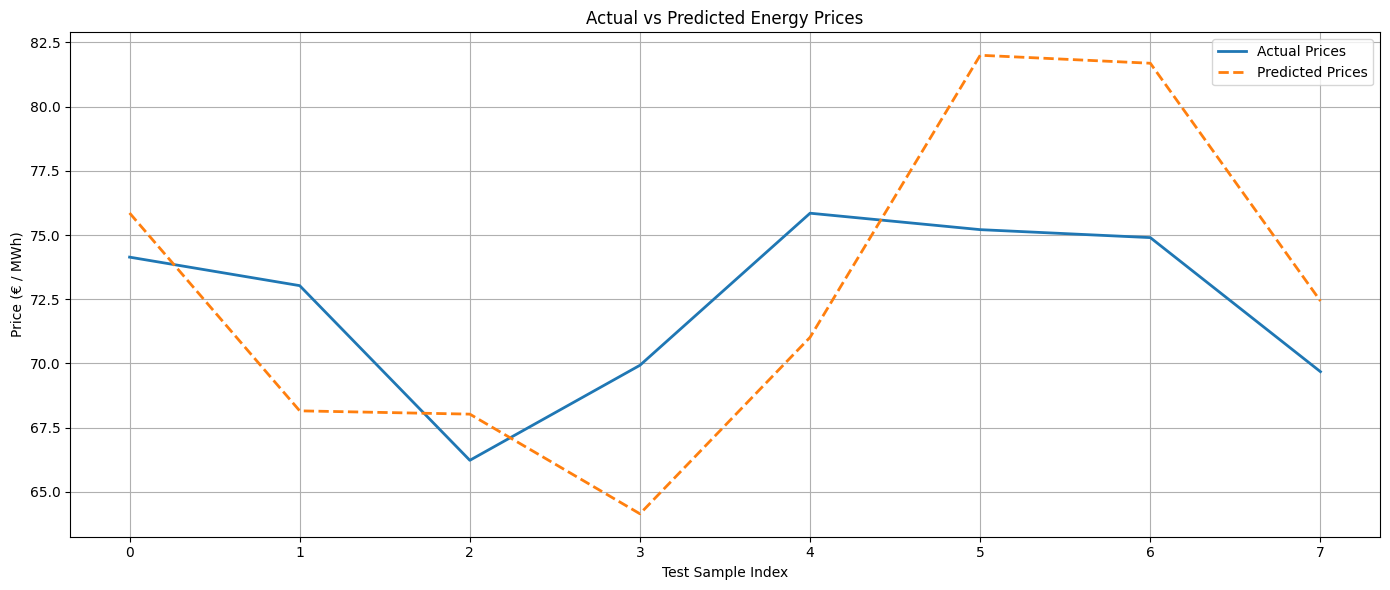

In [4]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual Prices', linewidth=2)
plt.plot(y_test_pred, label='Predicted Prices', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Energy Prices")
plt.xlabel("Test Sample Index")
plt.ylabel("Price (€ / MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

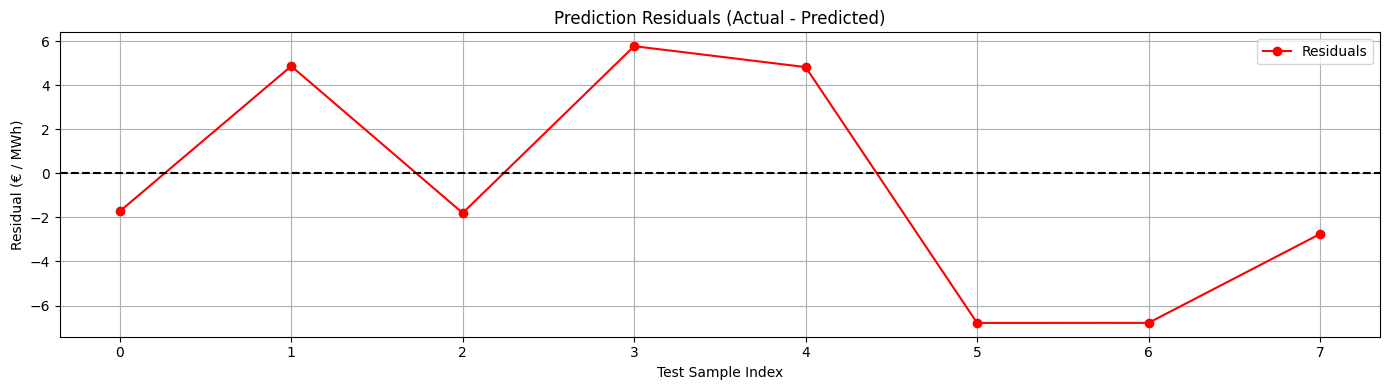

In [20]:
# Plot prediction errors (residuals)
plt.figure(figsize=(14, 4))
residuals = y_test.values - y_test_pred
plt.plot(residuals, color='red', marker='o', linestyle='-', label='Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.title("Prediction Residuals (Actual - Predicted)")
plt.xlabel("Test Sample Index")
plt.ylabel("Residual (€ / MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

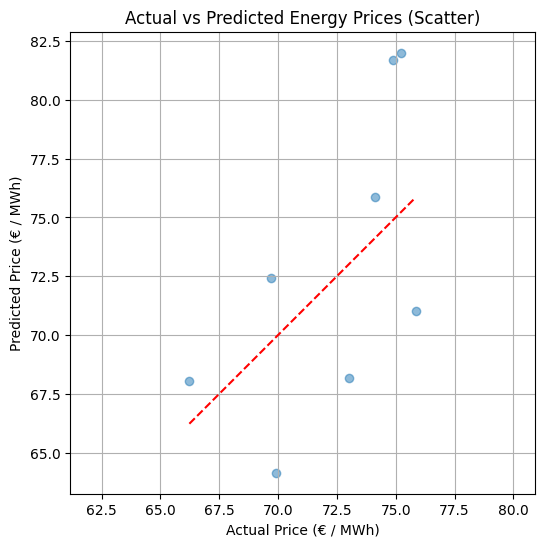

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (€ / MWh)")
plt.ylabel("Predicted Price (€ / MWh)")
plt.title("Actual vs Predicted Energy Prices (Scatter)")
plt.grid(True)
plt.axis('equal')
plt.show()

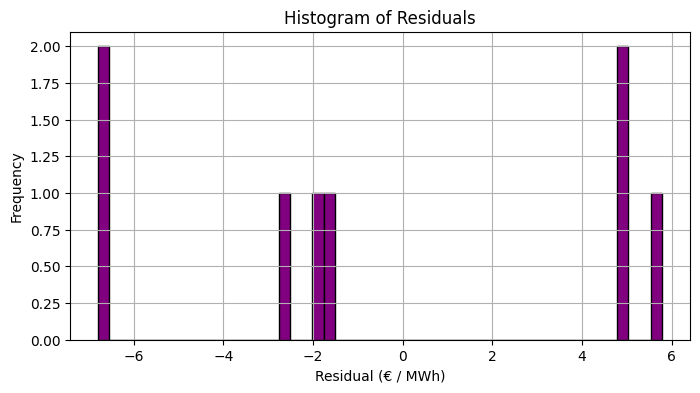

In [22]:
plt.figure(figsize=(8, 4))
plt.hist(y_test - y_test_pred, bins=50, color='purple', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residual (€ / MWh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

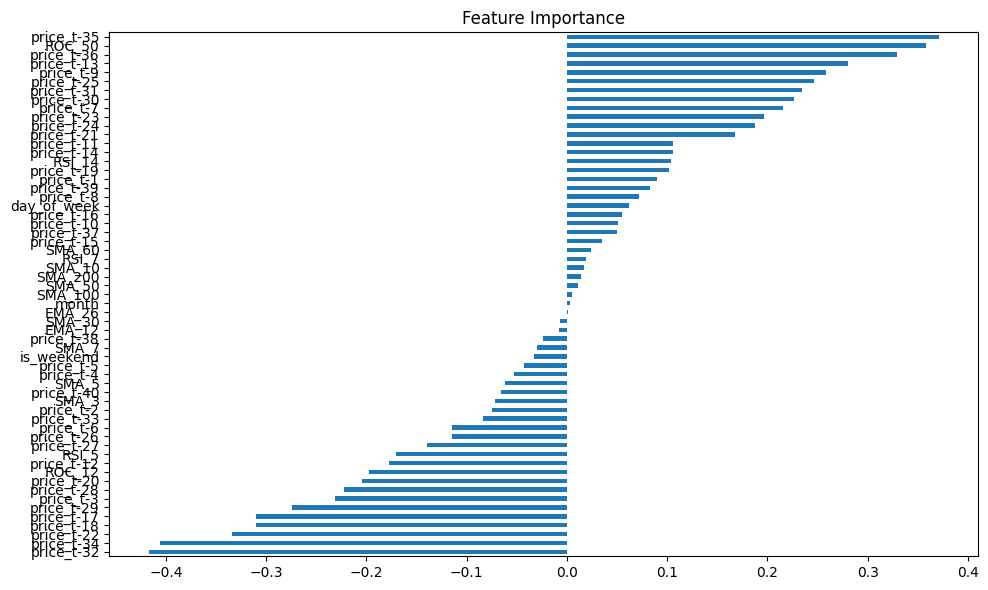

In [23]:
coefficients = pd.Series(model.coef_, index=X.columns)
coefficients.sort_values().plot(kind='barh', figsize=(10, 6), title="Feature Importance")
plt.tight_layout()
plt.show()